## Convolution - Recurrent Model

This notebook estimates a neural network model with convolution and recurrent layers. This version has a train/test split by subject.

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import BatchNormalization, LSTM, Activation, Dense, Dropout, GRU,Conv1D,MaxPooling1D
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import itertools

Using TensorFlow backend.


In [149]:
# need all of this to get reproducible results in Keras
# source: https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [2]:
# read cleaned model data (10 subjects)
df = pd.read_pickle('./data/thigh_clean.pkl')

In [3]:
df.head()

,attr_time_gyr,attr_x_gyr,attr_y_gyr,attr_z_gyr,attr_time_acc,attr_x_acc,attr_y_acc,attr_z_acc,activity,label,subject,sample_num
800,1435996984038,-0.786994,-0.328964,0.244081,1435996984038,0.469264,4.292205,1.912369,climbingdown,0,1,8
801,1435996984056,-0.539593,-0.340265,0.329907,1435996984056,0.769736,5.878364,2.906561,climbingdown,0,1,8
802,1435996984076,-0.334953,-0.454802,0.377860,1435996984076,1.098939,7.167043,3.312977,climbingdown,0,1,8
803,1435996984099,-0.086331,-0.496036,0.339070,1435996984099,1.409586,6.937798,4.225766,climbingdown,0,1,8
804,1435996984118,0.157099,-0.525052,0.350982,1435996984118,1.442507,6.427235,5.054759,climbingdown,0,1,8


In [4]:
df.subject.value_counts(1)

5     0.108505
8     0.106739
3     0.105781
9     0.105125
6     0.104066
10    0.103460
2     0.103360
1     0.098416
4     0.084140
7     0.080408
Name: subject, dtype: float64

In [5]:
df.activity.value_counts(1)

sitting         0.160513
standing        0.159554
walking         0.158697
lying           0.157284
climbingup      0.125303
running         0.119552
climbingdown    0.106638
jumping         0.012460
Name: activity, dtype: float64

In [5]:
# create pa (physical activity) recode: 8 --> 3 classes
df['pa']=df.activity.replace({'sitting':'sedentary','standing':'sedentary','walking':'lm','lying':'sedentary','climbingup':'lm',
                     'running':'vigorous','climbingdown':'lm','jumping':'vigorous'})

In [6]:
# create integer version in order to do 1-hot encoding
df['pa_label']=df.pa.replace({'sedentary':0,'lm':1,'vigorous':2})

In [56]:
# train/test split 
# subjects 1 to 7 are in train, subjects 8 to 10 are in test
columns =[
     'attr_x_gyr','attr_y_gyr','attr_z_gyr',
          'attr_x_acc','attr_y_acc','attr_z_acc']
train_mask = df.subject <= 7
test_mask = df.subject >= 8
X_train = df[columns][train_mask]
X_test = df[columns][test_mask]

In [57]:
# Create y
y_train=df[train_mask].pa_label.groupby(df.sample_num).mean()
y_test=df[test_mask].pa_label.groupby(df.sample_num).mean()

In [58]:
y_train.shape

(13573,)

In [59]:
y_test.shape

(6251,)

In [60]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [61]:
X_train.shape

(1357300, 6)

In [62]:
X_test.shape

(625100, 6)

In [63]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = np.array(X_train).reshape((-1,100,6))  # reshape into a series of 100x6 arrays - windowsize x num_features
X_test = np.array(X_test).reshape((-1,100,6))

In [64]:
y_train.shape

(13573, 3)

In [150]:
# create model instance
model = Sequential()

# add model layers
model.add(Conv1D(filters=50, kernel_size=3,input_shape=(X_train.shape[1], 6),activation='relu'))
model.add(MaxPooling1D(pool_size=4,padding='valid'))
model.add(BatchNormalization())
model.add(Conv1D(filters=50, kernel_size=3,activation='relu'))
model.add(MaxPooling1D(pool_size=2,padding='valid'))
model.add(BatchNormalization())
model.add(GRU(
    units=64,
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    return_sequences=True,  # because the next layer is also GRU
    dropout=0.0, #0.303
    recurrent_dropout=0.0, #0.458 
    ))   
model.add(GRU(
    units=64,
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    return_sequences=False,  # because the next layer is dense 
#     dropout=0.2, # 0.196
     recurrent_dropout=0.2  # 0.073
    ))
model.add(Dropout(0.1))
model.add(Dense(3, kernel_initializer='uniform',activation='softmax'))

In [151]:
# compile and summarize model
model.compile(loss='categorical_crossentropy', 
             optimizer=Adam(lr=0.001), 
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 98, 50)            950       
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 24, 50)            0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 24, 50)            200       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 22, 50)            7550      
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 11, 50)            0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 11, 50)            200       
_________________________________________________________________
gru_30 (GRU)                 (None, 11, 64)            22080     
__________

In [152]:
# estimate model
result = model.fit(X_train, y_train, epochs=2, batch_size=25, 
                   validation_data=(X_test,y_test), #callbacks=[early_stop]) #, model_saver]
                  )

Train on 13573 samples, validate on 6251 samples
Epoch 1/2
13573/13573 [==============================] - 48s 4ms/step - loss: 0.0680 - acc: 0.9848 - val_loss: 0.1351 - val_acc: 0.9581
Epoch 2/2
13573/13573 [==============================] - 34s 3ms/step - loss: 0.0182 - acc: 0.9954 - val_loss: 0.1860 - val_acc: 0.9606


In [153]:
# get accuracy measures per class
# source: https://stackoverflow.com/questions/45930750/how-to-output-per-class-accuracy-in-keras
Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(X_test)
print(classification_report(Y_test, y_pred, 
                            target_names=["sedentary","lm","vigorous"]))

              precision    recall  f1-score   support

   sedentary       0.99      1.00      0.99      2859
          lm       0.93      0.99      0.96      2479
    vigorous       0.99      0.75      0.86       913

    accuracy                           0.96      6251
   macro avg       0.97      0.92      0.94      6251
weighted avg       0.96      0.96      0.96      6251



In [154]:
# source: https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    
    
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout();

<Figure size 432x288 with 0 Axes>

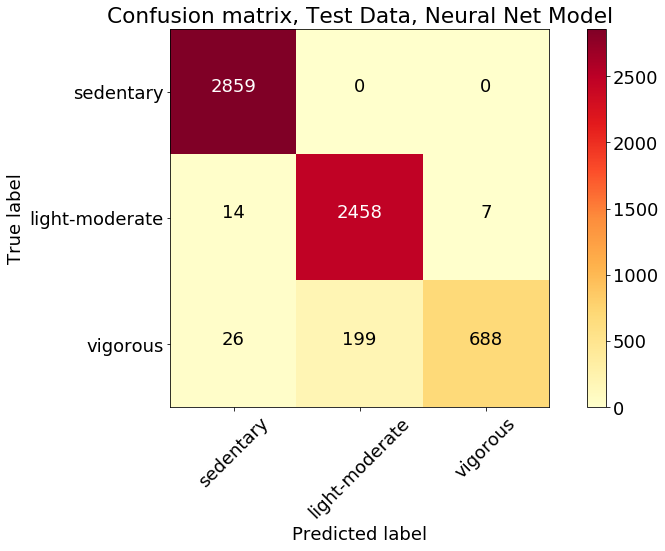

In [155]:
np.set_printoptions(precision=2)
cm = confusion_matrix(Y_test, 
                      y_pred, 
                      )
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, 
                      classes=["sedentary","light-moderate","vigorous"],
                      title='Confusion matrix, Test Data, Neural Net Model',
                        cmap='YlOrRd');


In [156]:
score, acc = model.evaluate(X_test, y_test, verbose=1)
print("Score: {}; acc: {}".format(score, acc))

6251/6251 [==============================] - 5s 827us/step
Score: 0.18604879641558733; acc: 0.9606462965925452


## Test on held-out data for remaining 5 subjects

In [157]:
# re-estimate model on all data (all 10 subjects in modeling data)
y = df.pa_label.groupby(df.sample_num).mean()
y = to_categorical(y, 3)

X = df[columns]
sc_10 = StandardScaler()
X = sc_10.fit_transform(X)
X = np.array(X).reshape((-1,100,6))

In [161]:
# save model for later use
pkl_filename = "./data/model_conv_sub.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(model, file)

In [158]:
result = model.fit(X, y, epochs=2, batch_size=25)

Epoch 1/2
19824/19824 [==============================] - 44s 2ms/step - loss: 0.0178 - acc: 0.9954
Epoch 2/2
19824/19824 [==============================] - 43s 2ms/step - loss: 0.0076 - acc: 0.9981


In [52]:
# read validation data
validate = pd.read_pickle('./thigh_validate_clean.pkl')

In [30]:
# create pa (physical activity) recode: 8 --> 3 classes
validate['pa']=validate.activity.replace({'sitting':'sedentary','standing':'sedentary','walking':'lm','lying':'sedentary','climbingup':'lm',
                     'running':'vigorous','climbingdown':'lm','jumping':'vigorous'})
validate['pa_label']=validate.pa.replace({'sedentary':0,'lm':1,'vigorous':2})
y_valid=validate.pa_label.groupby(validate.sample_num).mean()

In [74]:
X_valid = validate[columns]
X_valid = sc_10.transform(X_valid)
X_valid = np.array(X_valid).reshape((-1,100,6))

In [159]:
# get accuracy measures per class
# source: https://stackoverflow.com/questions/45930750/how-to-output-per-class-accuracy-in-keras
# Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_valid_pred = model.predict_classes(X_valid)
print(classification_report(y_valid, y_valid_pred, 
                            target_names=["sedentary","lm","vigorous"]))

              precision    recall  f1-score   support

   sedentary       1.00      1.00      1.00      4728
          lm       0.97      0.99      0.98      3614
    vigorous       0.99      0.94      0.97      1551

    accuracy                           0.99      9893
   macro avg       0.99      0.98      0.98      9893
weighted avg       0.99      0.99      0.99      9893



<Figure size 432x288 with 0 Axes>

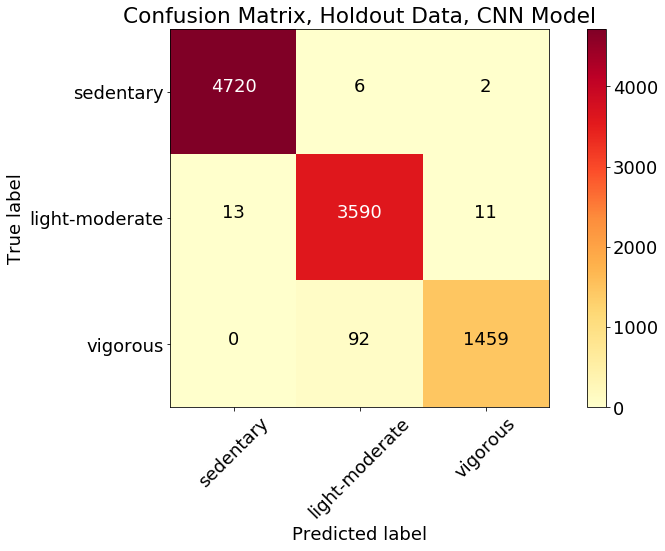

In [162]:
cm = confusion_matrix(y_valid, 
                      y_valid_pred, 
                      )
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, 
                      classes=["sedentary","light-moderate","vigorous"],
                      title='Confusion Matrix, Holdout Data, CNN Model',
                     cmap='YlOrRd');
